In [1]:
import pandas as pd
import matplotlib.pyplot as plt

**<font size=5>Ⅰ数据预处理</font>**

<font size=4>1.读取数据</font>

In [2]:
filename = "2015O3data.csv"
data = pd.read_csv(filename, header = 0, encoding="utf-8")

<font size=4>2.查看数据</font>

In [3]:
data.dtypes

date           int64
hour           int64
O3           float64
O3_24h       float64
O3_8h        float64
O3_8h_24h    float64
dtype: object

In [4]:
data.shape

(8212, 6)

In [5]:
data.count()

date         8212
hour         8212
O3           8212
O3_24h       8212
O3_8h        8212
O3_8h_24h    8212
dtype: int64

In [6]:
data.describe()

,date,hour,O3,O3_24h,O3_8h,O3_8h_24h
count,8.212000e+03,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000
mean,2.015067e+07,11.462250,52.897224,109.132002,53.301875,91.991963
std,3.452091e+02,6.930324,45.960168,59.599868,41.482109,52.009482
min,2.015010e+07,0.000000,2.000000,5.000000,2.000000,4.000000
25%,2.015040e+07,5.000000,17.000000,60.000000,21.000000,49.000000
50%,2.015070e+07,11.000000,40.000000,103.000000,43.000000,86.000000
75%,2.015100e+07,18.000000,74.000000,152.000000,75.000000,130.000000
max,2.015123e+07,23.000000,277.000000,279.000000,246.000000,248.000000


<font size=4>3.时间的处理</font>

In [7]:
data["hournew"] = data["hour"].map(lambda x:("%02d")%x)

data["datetime"] = data["date"].map(str) + data["hournew"].map(str)

data["datetime"] = pd.to_datetime(data["datetime"], format="%Y%m%d%H")

In [8]:
data["year"] = pd.DatetimeIndex(data.datetime).year
data["month"] = pd.DatetimeIndex(data.datetime).month
data["day"] = pd.DatetimeIndex(data.datetime).day

In [9]:
data = data.drop(["date", "hournew"], axis=1)

In [10]:
data = data.set_index("datetime")
#存储索引，以便后期绘图
dataIndex = data.index

<font size=4>4.调整一下数据的位置</font>

In [11]:
orderlist = ["year", "month", "day", "hour", "O3", "O3_24h", "O3_8h", "O3_8h_24h"]
data = data[orderlist]
print(data.head())

                     year  month  day  hour    O3  O3_24h  O3_8h  O3_8h_24h
datetime                                                                   
2015-01-02 00:00:00  2015      1    2     0  40.0   103.0   43.0       86.0
2015-01-02 01:00:00  2015      1    2     1  11.0    47.0   11.0       36.0
2015-01-02 02:00:00  2015      1    2     2  10.0    47.0   11.0       36.0
2015-01-02 03:00:00  2015      1    2     3  13.0    47.0   11.0       36.0
2015-01-02 04:00:00  2015      1    2     4  15.0    47.0   11.0       36.0


<font size=4>5.查看原始数据</font>

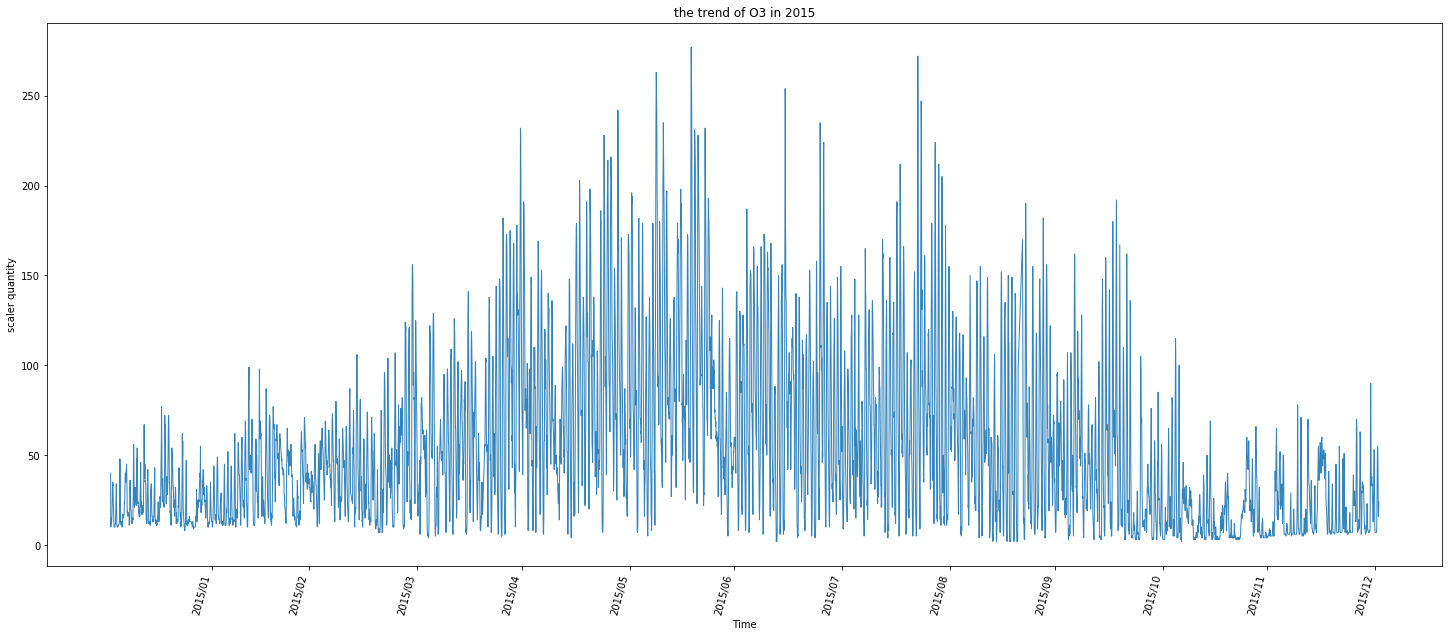

In [12]:
plt.figure(figsize=(25,10))
xticks = pd.date_range(start=dataIndex.min(), end = dataIndex.max(), freq="m")
plt.xticks(xticks, xticks.strftime("%Y/%m"), rotation=75, ha="right")
plt.plot(data["O3"], linewidth=1, alpha=0.9)
plt.xlabel("Time")
plt.ylabel("scaler quantity")
plt.title("the trend of O3 in 2015")
plt.show()

In [13]:
%matplotlib

Using matplotlib backend: Qt5Agg


**<font size=5>Ⅱ边缘权重因子</font>**

**<font size=4 color="blue">用于确定子时间序列的边界点</font>**

1. 首先要确定检测窗口的宽度，然后找到检测窗口中的最大值与最小值

In [14]:
#假设将检测窗口的宽度设置为24（即一天）
w = 12

先用一天的数据做一个实验

In [19]:
datatest = data["O3"].iloc[:72]

In [20]:
datatest.head()

datetime
2015-01-02 00:00:00    40.0
2015-01-02 01:00:00    11.0
2015-01-02 02:00:00    10.0
2015-01-02 03:00:00    13.0
2015-01-02 04:00:00    15.0
Name: O3, dtype: float64

查看这一天的数据图像

In [21]:
datatestIndex = datatest.index

In [60]:
plt.figure(figsize=(25,10))
xticks = pd.date_range(start=datatestIndex.min(), end = datatestIndex.max(), freq="H")
plt.xticks(xticks, xticks.strftime("%Y/%m:%H"), rotation=75, ha="right")
plt.plot(datatest, linewidth=2, alpha=0.9)
plt.xlabel("Time")
plt.ylabel("scaler quantity")
plt.title("the trend of test O3 in 2015")
plt.show()

In [23]:
testarray = datatest.values

In [24]:
testarray.shape

(72,)

In [25]:
wlist = []

对前w个数据和后w个数据即一个窗口单独处理

<font color="red">其实按理说，第一个点和最后一个数据|应该标为异常点</font>

In [27]:
forewindowarray = testarray[:w]

#计算第一个窗口的最大值、最小值和标准差
wmin = forewindowarray.min()
wmax = forewindowarray.max()
wstd = forewindowarray.std()

forepointnum = 0
forelist = []
for i in range(w):
    if forewindowarray[i] > wmax - wstd:
        forepointnum += 1
        forelist.append(i)
print("第一个窗口中候选异常数据有：", forepointnum, "个")
print("第一个窗口中的异常数据下标是:", forelist)

第一个窗口中候选异常数据有： 1 个
第一个窗口中的异常数据下标是: [0]


对最后一个窗口做相同的处理

In [33]:
lastwindowarray = testarray[len(testarray)-w:]

#计算第一个窗口的最大值、最小值和标准差
wmin = lastwindowarray.min()
wmax = lastwindowarray.max()
wstd = lastwindowarray.std()

lastpointnum = 0
lastlist = []
for i in range(w):
    if lastwindowarray[i] > wmax - wstd:
        lastpointnum += 1
        lastlist.append(len(testarray) - w + i)
print("第一个窗口中候选异常数据有：", lastpointnum, "个")
print("第一个窗口中的异常数据下标是:", lastlist)

第一个窗口中候选异常数据有： 1 个
第一个窗口中的异常数据下标是: [71]


对中间的元素进行统一的异常检测

In [36]:
import numpy as np

利用一个数组来存放异常点出现的次数

In [37]:
outlierarray = np.zeros_like(testarray)

定义一个函数用于异常点检测，当异常元素出现的时候，就存储下这个异常元素的下标，并加1.

In [39]:
def testOutlier(outlierarray, pointlist):
    for i in range(len(pointlist)):
        outlierarray[pointlist[i]] += 1
    return outlierarray

In [40]:
for i in range(1,len(testarray)-w):
    #将第i个元素到第i+w-1个元素记为一个检测窗口
    windowarray = testarray[i:i+w]
    #计算窗口的最大值、最小值和标准差
    wmin = windowarray.min()
    wmax = windowarray.max()
    wstd = windowarray.std()
    
    print("({:},{:}), min:{}, max:{}, std:{}".format(i, i+w-1, wmin, wmax, wstd))
    
    maxpoint = 0
    pointlist = []
    for j in range(len(windowarray)):
        
        if windowarray[j] >= wmax - wstd:
                maxpoint += 1
                pointlist.append(i+j)
    outlierarray = testOutlier(outlierarray,pointlist)
    print(maxpoint)
    print(pointlist)

(1,12), min:10.0, max:29.0, std:5.324863065531983
2
[11, 12]
(2,13), min:10.0, max:33.0, std:6.921684926535029
2
[12, 13]
(3,14), min:12.0, max:35.0, std:8.003471469028646
3
[12, 13, 14]
(4,15), min:12.0, max:35.0, std:8.50816601206681
4
[12, 13, 14, 15]
(5,16), min:12.0, max:35.0, std:8.93922380423615
5
[12, 13, 14, 15, 16]
(6,17), min:13.0, max:35.0, std:8.539125638299666
6
[12, 13, 14, 15, 16, 17]
(7,18), min:13.0, max:35.0, std:7.940752833047731
6
[12, 13, 14, 15, 16, 17]
(8,19), min:14.0, max:35.0, std:7.123416003263852
6
[12, 13, 14, 15, 16, 17]
(9,20), min:16.0, max:35.0, std:6.3552253216458725
6
[12, 13, 14, 15, 16, 17]
(10,21), min:17.0, max:35.0, std:6.219927652312364
6
[12, 13, 14, 15, 16, 17]
(11,22), min:12.0, max:35.0, std:7.084313657652377
6
[12, 13, 14, 15, 16, 17]
(12,23), min:11.0, max:35.0, std:8.24452680402109
6
[12, 13, 14, 15, 16, 17]
(13,24), min:10.0, max:35.0, std:9.132892325119256
5
[13, 14, 15, 16, 17]
(14,25), min:10.0, max:35.0, std:9.366014212151411
4
[14,

In [41]:
outlierarray

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 12.,
       12., 12., 12., 12., 12.,  1.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  9., 12.,
       12., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       12., 12., 12.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.])

利用np.where函数，查找异常数据对应的下标

In [71]:
outlierIndex = np.where(outlierarray == 12)[0]

In [72]:
outlierIndex

array([12, 13, 14, 15, 16, 17, 38, 39, 40, 52, 53, 54], dtype=int64)

找到用于分隔的边缘点(待完成)

In [70]:
outlierIndex[0]

array([12, 13, 14, 15, 16, 17, 38, 39, 40, 52, 53, 54], dtype=int64)

In [69]:
outlierIndex[0] + 0 + 1 == outlierIndex[1]

IndexError: tuple index out of range

In [75]:
for i in range(len(outlierIndex)):
    lennum = 0
    for j in range(i+1,len(outlierIndex)):
        if outlierIndex[i] + j + 1 == outlierIndex[j]:
            lennum += 1
            continue
        else:
            print(i, j)
            break


0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11


In [73]:
outlier = datatest.iloc[outlierIndex]

In [74]:
plt.plot(outlier, color="red", linewidth=8, alpha=0.5)

In [44]:
outlierarray.nonzero(outlierarray.equals(12))

AttributeError: 'numpy.ndarray' object has no attribute 'equals'

In [80]:
maxlist = max(wlist)

In [81]:
seq = []

In [82]:
for i in range(len(wlist)):
    if wlist[i] == maxlist:
        seq.append(i)

In [83]:
seq

[6, 7, 8, 9, 10, 11, 12]

In [33]:
testarray.min()

10.0

In [26]:
testarray.max()

40.0

In [27]:
testarray.std()

9.110052445269213